In [ ]:
# COCO Dataset Loader Example
# First, let's import the COCO dataloader
import sys
import os
sys.path.append('/Users/konradburdach/final/Diffusion-Model-')

from data.coco_dataloader import get_coco_train_dataloader, COCODataset
import torch
import matplotlib.pyplot as plt

# Create dataloader with the same paths as before
train_loader = get_coco_train_dataloader(
    image_dir="~/Downloads/coco2017/train2017",
    annotations_file="~/Downloads/coco2017/annotations/captions_train2017.json",
    batch_size=4,
    image_size=64
)

print(f"Dataset size: {len(train_loader.dataset)}")
print(f"Number of batches: {len(train_loader)}")

# Get a sample batch
images, captions = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Number of captions: {len(captions)}")
print(f"Sample captions:")
for i, caption in enumerate(captions):
    print(f"  {i+1}: {caption}")

In [ ]:
# Visualize images from the batch
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(4, len(images))):
    # Convert from tensor to numpy and denormalize
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize from [-1, 1] to [0, 1]
    
    axes[i].imshow(img)
    axes[i].set_title(f"Caption: {captions[i][:50]}..." if len(captions[i]) > 50 else f"Caption: {captions[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import os, random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from models.UNET import ConditionalUNet
from models.CLIP import CLIPTextEncoder
from models.DDPM import DDPM


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [20]:
from config import ModelConfig, TrainConfig


batch_size = TrainConfig.batch_size
lr = TrainConfig.lr
timesteps = TrainConfig.timesteps

text_enc = CLIPTextEncoder().to(device)
text_enc.text_model.eval()
for p in text_enc.parameters(): p.requires_grad = False

model = ConditionalUNet(img_channels=ModelConfig.img_channels, base_ch=ModelConfig.base_ch, ch_mults=ModelConfig.chan_mults, ctx_dim=ModelConfig.embed_dim).to(device)
ddpm = DDPM(model, timesteps=TrainConfig.timesteps, device=device).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)

In [8]:
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from PIL import Image
func = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

In [24]:
path_images = "~/Downloads/coco2017/train2017"
path_images = os.path.expanduser(path_images)
path_captions = "~/Downloads/coco2017/annotations/captions_train2017.json"
path_captions = os.path.expanduser(path_captions)
import json
with open(path_captions, "r") as f:
    captions = json.load(f)
print(captions.keys())
id2file = {c["id"]: c["file_name"] for c in captions["images"]}
from collections import defaultdict
id2captions = defaultdict(list)
for c in captions["annotations"]:
    id2captions[c["image_id"]].append(c["caption"])
img = Image.open(os.path.join(path_images, id2file[list(id2file.keys())[0]])).convert("RGB")
img = func(img)  # shape: [3, 64, 64]
first_caption = id2captions[list(id2captions.keys())[0]][0]

"""
img_np = img.permute(1, 2, 0).numpy()  # shape: [64, 64, 3]
plt.imshow((img_np * 0.5 + 0.5))  # undo normalization for visualization
plt.axis("off")
plt.show()

print(id2captions[list(id2captions.keys())[0]])
"""

dict_keys(['info', 'licenses', 'images', 'annotations'])


'\nimg_np = img.permute(1, 2, 0).numpy()  # shape: [64, 64, 3]\nplt.imshow((img_np * 0.5 + 0.5))  # undo normalization for visualization\nplt.axis("off")\nplt.show()\n\nprint(id2captions[list(id2captions.keys())[0]])\n'

In [29]:
img = img.unsqueeze(0).expand(32, -1, -1, -1).to(device)  # (B, 3, 64, 64) - move to device
captions = [first_caption]*32  # (B,)
scaler = torch.amp.GradScaler(enabled=(device.type in ["cuda"]))

global_step = 0
model.train()
for epoch in range(TrainConfig.epochs * 1000):
        imgs = img  # img is already on device
        with torch.no_grad():
            context = text_enc.encode(list(captions), device=device)  # (B, L, C)
        t = torch.randint(0, TrainConfig.timesteps, (imgs.size(0),), device=device, dtype=torch.long)

        opt.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type if device.type != "mps" else "cpu", dtype=torch.float16, enabled=(device.type in ["cuda"])):
            loss = ddpm.loss(imgs, t, context)
        print(loss.item())
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

0.496870219707489
0.5065566301345825
0.5068100690841675
0.5075625777244568
0.48918890953063965
0.5167307257652283
0.5038546323776245
0.5223567485809326
0.48918890953063965
0.5167307257652283
0.5038546323776245
0.5223567485809326
0.5412812232971191
0.5063493251800537
0.505521297454834
0.5139034390449524
0.5412812232971191
0.5063493251800537
0.505521297454834
0.5139034390449524
0.4868674874305725
0.5058727264404297
0.5307209491729736
0.5117174386978149
0.4868674874305725
0.5058727264404297
0.5307209491729736
0.5117174386978149
0.49207553267478943
0.4792702794075012
0.46377652883529663
0.49323567748069763
0.49207553267478943
0.4792702794075012
0.46377652883529663
0.49323567748069763
0.5225180983543396
0.5167165994644165
0.4895787239074707
0.5214206576347351
0.5225180983543396
0.5167165994644165
0.4895787239074707
0.5214206576347351
0.5140774250030518
0.5054315328598022
0.5202093124389648
0.4972533881664276
0.5140774250030518
0.5054315328598022
0.5202093124389648
0.4972533881664276
0.51061

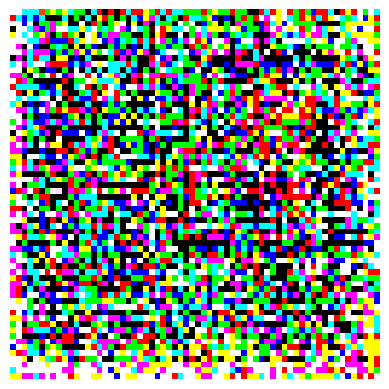

In [31]:
first_caption = id2captions[list(id2captions.keys())[0]][0]
context = text_enc.encode([''], device=device)  # (1, L, C)
B = 4
context = context.expand(B, -1, -1).contiguous()

imgs = ddpm.sample(shape=(B, 3, 64, 64), text_context=context, device=device, guidance_scale=5, text_encoder=text_enc)
imgs = (imgs.clamp(-1, 1) + 1) * 0.5
imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()
plt.imshow(imgs[0])
plt.axis("off")
plt.show() 

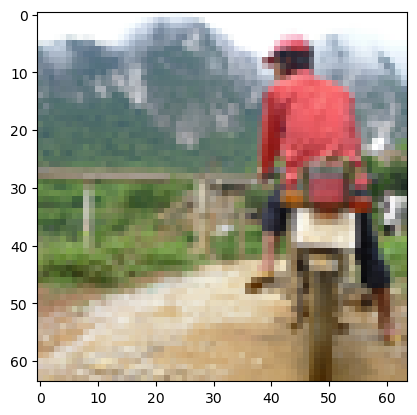

In [39]:
import numpy as np
img = Image.open(os.path.join(path_images, id2file[list(id2file.keys())[0]])).convert("RGB")
img = func(img)  # shape: [3, 64, 64]
img = img* 0.5 + 0.5
img.shape
img = np.transpose(img, (1, 2, 0))
first_caption = id2captions[list(id2captions.keys())[0]][0]
plt.imshow(img)

In [22]:

from models.VAE import VAE
from config import ModelConfig
import torch
vae = VAE(
            in_channels=3,
            latent_dim=ModelConfig.vae_latent_dim,
            base_channels=ModelConfig.vae_base_channels,
            kl_weight=ModelConfig.vae_kl_weight
        ).to(torch.device("cuda"))

In [25]:
img = img.unsqueeze(0).expand(8, -1, -1, -1).to(torch.device("cuda"))

In [28]:
vae_optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-5)
vae.train()

for epoch in range(10000):
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
        
    vae_optimizer.zero_grad()
    recon, mean, logvar, _ = vae(img)
    loss, recon_loss, kl_loss = vae.loss_function(recon, img, mean, logvar)
    
    loss.backward()
    vae_optimizer.step()
    
    total_loss += loss.item()
    total_recon_loss += recon_loss.item()
    total_kl_loss += kl_loss.item()
    print(f"total loss {total_loss}, recon loss {total_recon_loss}, kl loss {total_kl_loss}")

total loss 66.28357696533203, recon loss 66.28303527832031, kl loss 540.9853515625
total loss 1135.9703369140625, recon loss 1135.9697265625, kl loss 586.4002075195312
total loss 253.44644165039062, recon loss 253.44586181640625, kl loss 583.0355224609375
total loss 239.79771423339844, recon loss 239.79714965820312, kl loss 567.6527709960938
total loss 480.4985656738281, recon loss 480.4980163574219, kl loss 553.0717163085938
total loss 357.07733154296875, recon loss 357.0767822265625, kl loss 552.3239135742188
total loss 185.75921630859375, recon loss 185.75865173339844, kl loss 559.6200561523438
total loss 119.63789367675781, recon loss 119.63732147216797, kl loss 569.404296875
total loss 133.03884887695312, recon loss 133.03826904296875, kl loss 578.510986328125
total loss 168.23843383789062, recon loss 168.23785400390625, kl loss 585.1394653320312
total loss 188.1742401123047, recon loss 188.17364501953125, kl loss 588.0308837890625
total loss 180.34681701660156, recon loss 180.346

In [31]:
a = torch.randn(1, 4, 8, 8)
c = vae.decode_from_latent(a.to(torch.device("cuda")))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05666086..1.1244898].


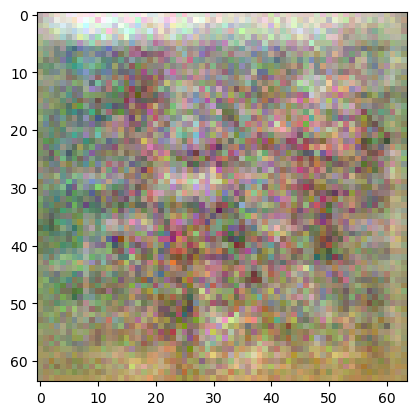

In [32]:
plt.imshow(c[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)

In [ ]:
for epoch in range(epochs):
        pbar = tqdm(dl, desc=f"Diffusion Epoch {epoch+1}/{epochs}")
        for imgs, captions in pbar:
            imgs = imgs.to(device)
            
            with torch.no_grad():
                context = text_enc.encode(list(captions), device=device)  # (B, L, C)
            
            # Encode images to latent space if using VAE
            if vae is not None:
                if train_vae_epochs > 0:  # Pre-trained VAE
                    with torch.no_grad():
                        latents = vae.encode_to_latent(imgs)
                else:  # Joint training
                    latents, _, _ = vae.encode(imgs)
                    latents = vae.reparameterize(*_)
                
                # Scale latents (common practice in latent diffusion)
                latents = latents * 0.18215
                x_input = latents
            else:
                x_input = imgs

            t = torch.randint(0, timesteps, (x_input.size(0),), device=device, dtype=torch.long)

            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device.type if device.type != "mps" else "cpu", dtype=torch.float16, enabled=(device.type in ["cuda"])):
                if vae is not None and train_vae_epochs == 0:
                    # Joint training - add VAE reconstruction loss
                    diffusion_loss = ddpm.loss(x_input, t, context)
                    recon, mean, logvar, _ = vae(imgs)
                    vae_loss, _, _ = vae.loss_function(recon, imgs, mean, logvar)
                    loss = diffusion_loss + 0.1 * vae_loss  # Weight VAE loss lower
                else:
                    # Pre-trained VAE or no VAE
                    loss = ddpm.loss(x_input, t, context)
                    
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            global_step += 1
            pbar.set_postfix(loss=float(loss.detach().cpu()))


NameError: name 'torch' is not defined